In [30]:
%load_ext autoreload
%autoreload 2
import torch
from torch import nn
import torch.functional as F
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from model import Encoder, Decoder, SelfAttentionEncoder, AutoEncoder, get_trainable_params
print(torch.__version__)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2.0.0


In [20]:
#Test
input_dim = 500
factor_dim = 20
enc = SelfAttentionEncoder(hidden_dim = [input_dim, 200, 100, factor_dim])
X = torch.randn(64, input_dim)
res = enc.forward(X)
print(res.shape)
#print(enc)

#Test
input_dim = 500
factor_dim = 20
dec = Decoder(hidden_dim = [factor_dim, 100, input_dim])
X = torch.randn(64, factor_dim)
res = dec.forward(X)
print(res.shape)
#print(dec)

mod = AutoEncoder(enc, dec)
X = torch.randn(64, input_dim)
res = mod.forward(X)
print(res.shape)

#print(mod)

torch.Size([64, 20])
torch.Size([64, 500])
torch.Size([64, 500])


In [42]:
def train(X: torch.utils.data.DataLoader, model: AutoEncoder, n_epoch:int, optimizer: optim.Optimizer, criterion: nn.Module, lr: float = 0.05):
    """
    Vanilla gradient descent using Adam
    """
    optimizer = optimizer(model.parameters(), lr=lr)
    loss_hist = []
    for epoch in range(n_epoch):
        running_loss = 0.0
        for i, batch in enumerate(X):
            optimizer.zero_grad()
            out = model(batch)
            loss  = criterion(out, batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        loss_hist.append(running_loss/len(X))
        print(f"Epoch {epoch} | {loss_hist[-1]}", end='\r')
    return loss_hist

In [26]:
def simulateVar(x0, delta, lamda, T, mu, omega):
    assert delta.shape[0] == x0.shape[0] == lamda.shape[0] == x0.shape[0] == omega.shape[0] == mu.shape[0], 'Incorrect shapes'
    eigval, _ = np.linalg.eig(lamda)
    if not (np.abs(eigval)<=1.).all(): print(f"Warning: this system is unstable. Eigenvalues: {eigval}")
    res = [x0]
    for t in range(T):
        residuals = np.random.multivariate_normal(mu,omega)
        xt = delta + lamda @ res[-1] + residuals
        res.append(xt)
    return np.array(res)

def simulateRandomVar(k, T=100, warmup=0.1):
    D = np.diag(np.random.uniform(0,1, size=(k))) #eigenvalues
    V = np.random.normal(size=(k,k))
    lamda = np.linalg.inv(V) @ D @ V #similarity transform
    #print(np.linalg.eig(lamda))
    x0 = np.random.normal(size=(k))
    delta = np.random.normal(size=(k))
    mu = np.zeros(k)
    omega = np.identity((k))
    res = simulateVar(x0,delta,lamda,T,mu,omega)
    return res[int(0.1*T):]



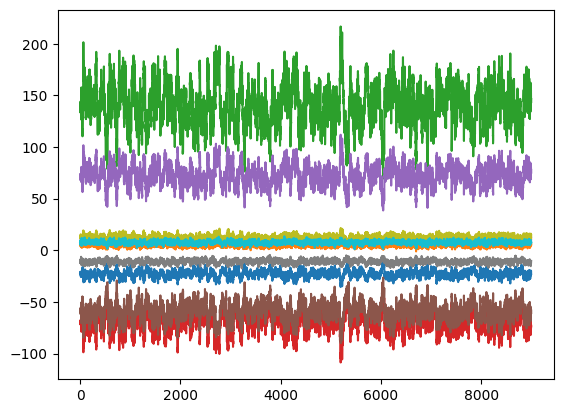

In [27]:
sim = simulateRandomVar(10,T=10000)
plt.plot(sim);

471
AutoEncoder(
  (enc): SelfAttentionEncoder(
    (activation): Identity()
    (sequential): Sequential(
      (0): Linear(in_features=10, out_features=1, bias=True)
      (1): Identity()
    )
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
    )
  )
  (dec): Decoder(
    (activation): Tanh()
    (sequential): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
    )
  )
)


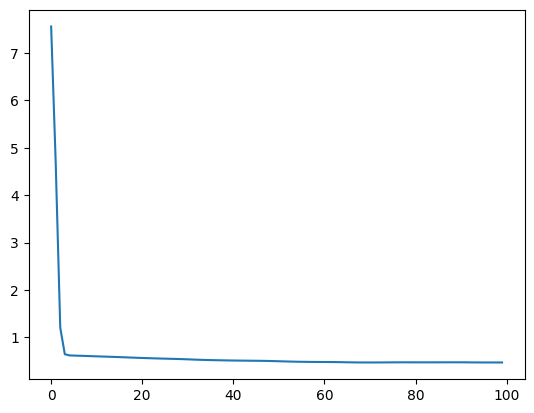

In [44]:
x = torch.from_numpy(sim).float()
dataLoader = torch.utils.data.DataLoader(x, batch_size=256, shuffle=False)
input_dim = 10
factor_dim = 1
enc = SelfAttentionEncoder(hidden_dim = [input_dim, factor_dim], activation=nn.Identity()) #fully linear
dec = Decoder(hidden_dim = [factor_dim, input_dim])
model = AutoEncoder(enc, dec)
print(get_trainable_params(model))
print(model)
loss_hist = train(X=dataLoader, model=model, n_epoch=100, optimizer=optim.Adam, criterion=nn.MSELoss(), lr=0.02)
plt.plot(np.log(loss_hist))

Text(0.5, 1.0, 'First principal component')

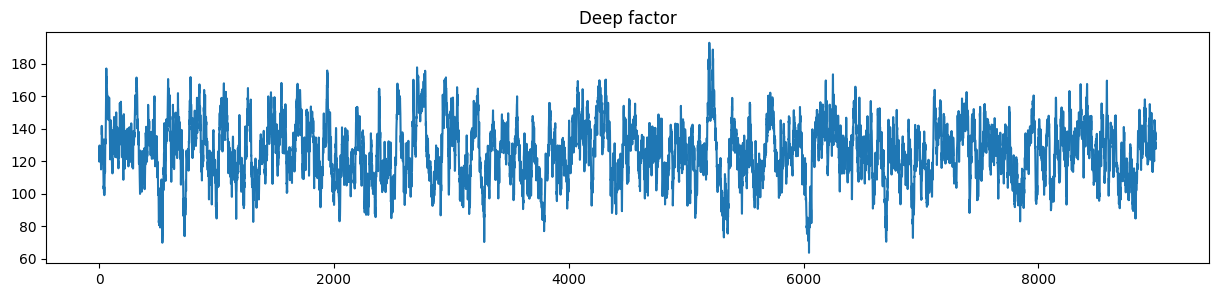

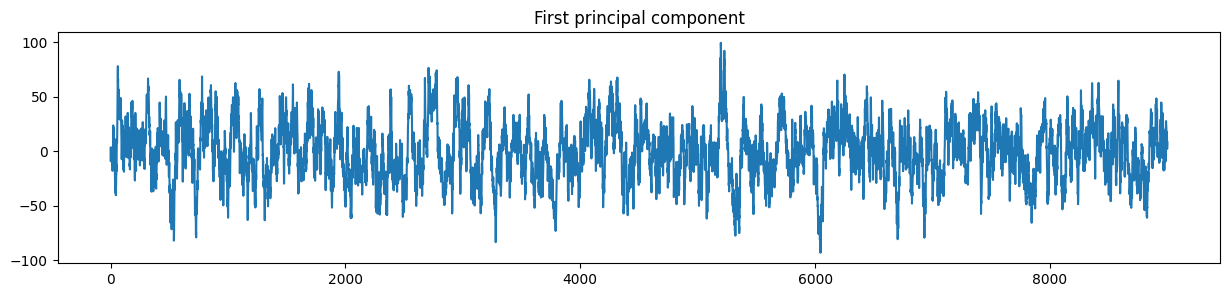

In [29]:
#plot factors
plt.figure(figsize=(15,3))
plt.plot(model.enc(x).detach().numpy());
plt.title('Deep factor')

#compare to PCA
pca = PCA(n_components=1)
pc = pca.fit_transform(x)
plt.figure(figsize=(15,3))
plt.plot(pc);
plt.title('First principal component')


Text(0.5, 1.0, '$\\hat y$')

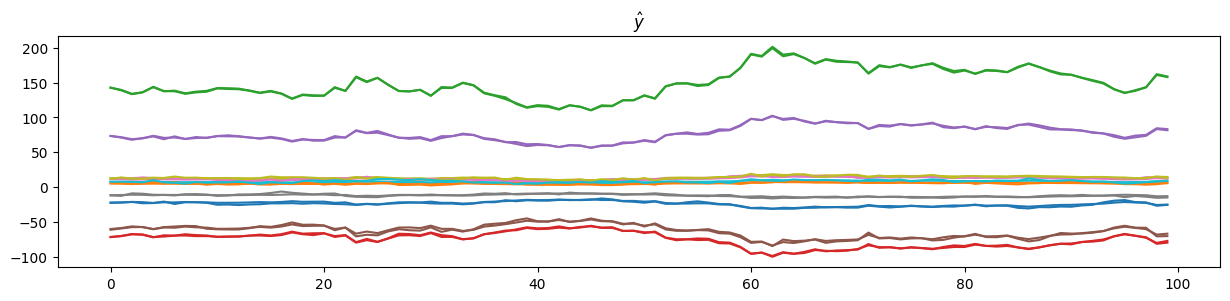

In [45]:
#plot reconstructed y_hat
plt.figure(figsize=(15,3))
y_hat = model(x).detach().numpy()
plt.plot(y_hat[0:100]);
plt.plot(x[0:100])
plt.title('$\hat y$')